In [437]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [438]:
jackknife_file = '/mnt/store1/oliverphilcox/Mock1QPM3/xi_jack/xi_jack_n36_m12_j169_11.dat'
weight_dir = '/mnt/store1/oliverphilcox/Mock1QPM3/weights/'
file_root = '/mnt/store1/oliverphilcox/Mock1QPM3/'
m = 12
n_samples = 10

# Load jackknife xi estimates from data
print("Loading correlation function jackknife estimates from %s"%jackknife_file)
xi_jack = np.loadtxt(jackknife_file,skiprows=2)
n_bins = xi_jack.shape[1] # total bins
n_jack = xi_jack.shape[0] # total jackknives
n = n_bins//m # radial bins

weight_file = weight_dir+'jackknife_weights_n%d_m%d_j%d_11.dat'%(n,m,n_jack)
RR_file = weight_dir+'binned_pair_counts_n%d_m%d_j%d_11.dat'%(n,m,n_jack)

print("Loading weights file from %s"%weight_file)
weights = np.loadtxt(weight_file)[:,1:]

# First exclude any dodgy jackknife regions
good_jk=np.unique(np.where(np.isfinite(xi_jack))[0])
print("Using %d out of %d jackknives"%(len(good_jk),n_jack))
xi_jack = xi_jack[good_jk]
weights = weights[good_jk]

# Compute data covariance matrix
print("Computing data covariance matrix")
mean_xi = np.sum(xi_jack*weights,axis=0)/np.sum(weights,axis=0)
tmp = weights*(xi_jack-mean_xi)
data_cov = np.matmul(tmp.T,tmp)
denom = np.matmul(weights.T,weights)
data_cov /= (np.ones_like(denom)-denom)

print("Loading weights file from %s"%RR_file)
RR=np.loadtxt(RR_file)

def load_matrices(index,jack=True):
    """Load intermediate or full covariance matrices"""
    if jack:
        cov_root = file_root+'CovMatricesJack/'
    else:
        cov_root = file_root+'CovMatricesAll/'
    c2 = np.diag(np.loadtxt(cov_root+'c2_n%d_m%d_11_%s.txt'%(n,m,index)))
    c3 = np.loadtxt(cov_root+'c3_n%d_m%d_1,11_%s.txt'%(n,m,index))
    c4 = np.loadtxt(cov_root+'c4_n%d_m%d_11,11_%s.txt'%(n,m,index))
    if jack:
        EEaA1 = np.loadtxt(cov_root+'EE1_n%d_m%d_11_%s.txt' %(n,m,index))
        EEaA2 = np.loadtxt(cov_root+'EE2_n%d_m%d_11_%s.txt' %(n,m,index))
        RRaA1 = np.loadtxt(cov_root+'RR1_n%d_m%d_11_%s.txt' %(n,m,index))
        RRaA2 = np.loadtxt(cov_root+'RR2_n%d_m%d_11_%s.txt' %(n,m,index))
    
        # Compute disconnected term
        w_aA1 = RRaA1/np.sum(RRaA1,axis=0)
        w_aA2 = RRaA2/np.sum(RRaA2,axis=0)
        diff1 = EEaA1-w_aA1*EEaA1.sum(axis=0)
        diff2 = EEaA2-w_aA2*EEaA2.sum(axis=0)
        RRaRRb = np.matmul(np.asmatrix(RR).T,np.asmatrix(RR))
        fact = np.ones_like(c4)-np.matmul(np.asmatrix(weights).T,np.asmatrix(weights))
        cx = np.asarray(np.matmul(diff1.T,diff2)/np.matmul(fact,RRaRRb))
        c4+=cx
    
    # Now symmetrize and return matrices
    return c2,0.5*(c3+c3.T),0.5*(c4+c4.T)

# Load in full jackknife theoretical matrices
print("Loading best estimate of jackknife covariance matrix")
c2,c3,c4=load_matrices('full')

# Load in partial jackknife theoretical matrices
c2s,c3s,c4s=[],[],[]
for i in range(n_samples):
    print("Loading jackknife subsample %d of %d"%(i+1,n_samples))
    c2,c3,c4=load_matrices(i)
    c2s.append(c2)
    c3s.append(c3)
    c4s.append(c4)

# Compute inverted matrix
def Psi(alpha):
    """Compute precision matrix from covariance matrix, removing quadratic order bias terms."""
    c_tot = c2*alpha**2.+c3*alpha+c4
    partial_cov=[]
    for i in range(n_samples):
        partial_cov.append(alpha**2.*c2s[i]+alpha*c3s[i]+c4s[i])
    tmp=0.
    for i in range(n_samples):
        c_excl_i = np.mean(partial_cov[:i]+partial_cov[i+1:],axis=0)
        tmp+=np.matmul(np.linalg.inv(c_excl_i),partial_cov[i])
    D_est=(n_samples-1.)/n_samples * (-1.*np.eye(n_bins) + tmp/n_samples)
    Psi = np.matmul(np.eye(n_bins)-D_est,np.linalg.inv(c_tot))
    return Psi

def neg_log_L1(alpha):
    """Return negative log L1 likelihood between data and theory covariance matrices"""
    Psi_alpha = Psi(alpha)
    logdet = np.linalg.slogdet(Psi_alpha)
    if logdet[0]<0:
        # Remove any dodgy inversions
        return np.inf        
    return np.trace(np.matmul(Psi_alpha,data_cov))-logdet[1]

Loading correlation function jackknife estimates from /mnt/store1/oliverphilcox/Mock1QPM3/xi_jack/xi_jack_n36_m12_j169_11.dat
Loading weights file from /mnt/store1/oliverphilcox/Mock1QPM3/weights/jackknife_weights_n36_m12_j169_11.dat
Using 169 out of 169 jackknives
Computing data covariance matrix
Loading weights file from /mnt/store1/oliverphilcox/Mock1QPM3/weights/binned_pair_counts_n36_m12_j169_11.dat
Loading best estimate of jackknife covariance matrix
Loading jackknife subsample 1 of 10
Loading jackknife subsample 2 of 10
Loading jackknife subsample 3 of 10
Loading jackknife subsample 4 of 10
Loading jackknife subsample 5 of 10
Loading jackknife subsample 6 of 10
Loading jackknife subsample 7 of 10
Loading jackknife subsample 8 of 10
Loading jackknife subsample 9 of 10
Loading jackknife subsample 10 of 10


In [442]:
# Now optimize for shot-noise rescaling parameter alpha
print("Optimizing for the shot-noise rescaling parameter")
from scipy.optimize import fmin
alpha_best = fmin(neg_log_L1,1.)
print("Optimization complete - optimal rescaling parameter is %.6f"%alpha_best)


Optimizing for the shot-noise rescaling parameter
Optimization terminated successfully.
         Current function value: -1435591995799185.750000
         Iterations: 69
         Function evaluations: 144
Optimization complete - optimal rescaling parameter is 1.046769


## Compute residuals

In [443]:
#alpha_best = 1.05
# Compute jackknife and full covariance matrices
jack_cov = c4+c3*alpha_best+c2*alpha_best**2.
jack_prec = Psi(alpha_best)
c2f,c3f,c4f=load_matrices('full',jack=False)
full_cov = c4f+c3f*alpha_best+c2f*alpha_best**2.


In [444]:
r_bins = np.loadtxt('/mnt/store1/oliverphilcox/Mock1QPM3/radial_binning_cov.csv').mean(axis=1)
mu_bins_tmp = np.linspace(0.,1.,m+1)
mu_bins = np.mean([mu_bins_tmp[1:],mu_bins_tmp[:-1]],axis=0)

n=len(r_bins)
r_bins_all = np.concatenate([[r_bins[i] for _ in range(m)] for i in range(len(r_bins))])
mu_bins_all = np.hstack([mu_bins for _ in range(len(r_bins))])
r_matrix = np.matmul(np.asmatrix(r_bins_all).T,np.asmatrix(r_bins_all))

r_diff = []
for rr in r_bins:
    for rr2 in r_bins:
        r_diff.append(rr-rr2)
r_diff = np.unique(np.asarray(r_diff).round(8)) # remove rounding errors
mu_diff = []
for mu in mu_bins:
    for mu2 in mu_bins:
        mu_diff.append(mu-mu2)
mu_diff = np.unique(np.asarray(mu_diff).round(8)) # remove rounding errors

mu_edge = np.linspace(-1,1,len(mu_diff)+1)

delta_r = r_diff[1]-r_diff[0]
r_edge = np.arange(min(r_diff)-delta_r/2.,max(r_diff)+3.*delta_r/2.,delta_r)

mu_edges = np.vstack([mu_edge for _ in range(len(r_edge))])
r_edges = np.vstack([r_edge for _ in range(len(mu_edge))])

In [445]:
stacked_resid = np.zeros([len(mu_diff),len(r_diff)])
denom = np.zeros([len(mu_diff),len(r_diff)])
for i in range(len(resid)):
    for j in range(resid.shape[1]):
        r_index = np.where(r_bins_all[i]-r_bins_all[j]==r_diff)
        mu_index = np.where((mu_bins_all[i]-mu_bins_all[j]).round(4)==mu_diff.round(4))
        stacked_resid[mu_index,r_index]=resid[i,j]
        denom[mu_index,r_index]+=1
stacked_resid/=denom

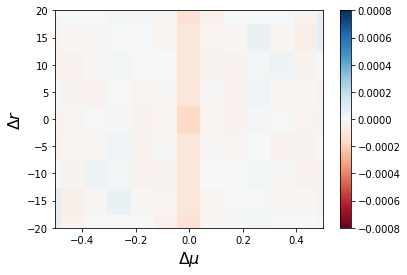

In [446]:
vmax=0.0008
plt.pcolor(mu_edges.T,r_edges,stacked_resid,cmap=cm.RdBu,vmax=vmax,vmin=-vmax)
plt.ylim([-20,20]);
plt.xlim([-0.5,0.5])
plt.colorbar();FS=16
plt.ylabel(r'$\Delta r$',fontsize=FS);plt.xlabel(r'$\Delta\mu$',fontsize=FS);

## Plot data jackknife covariance

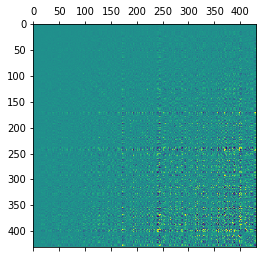

In [469]:
mat=np.linalg.inv(c2+c3+c4)
vmax = np.percentile(mat,99.9)
plt.matshow(mat,vmax=vmax,vmin=-vmax);
#plt.ylim([144,72])
#plt.xlim([72,144]);

In [476]:
xi=np.loadtxt('/mnt/store1/oliverphilcox/Mock1QPM3/xi/xi_n200_m120_11.dat',skiprows=2)
xi_r = np.genfromtxt('/mnt/store1/oliverphilcox/Mock1QPM3/xi/xi_n200_m120_11.dat',max_rows=1)

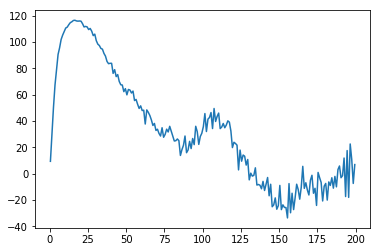

In [479]:
plt.plot(xi_r,xi_r**2.*xi.mean(axis=1))

## Look at eigenvalues

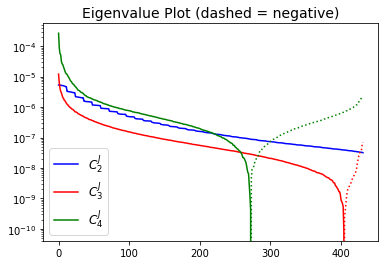

In [449]:
eig4 = np.linalg.eigvalsh(c4)
eig3 = np.linalg.eigvalsh(c3)
eig2 = np.linalg.eigvalsh(c2)
plt.plot(eig2[::-1],label=r'$C^J_2$',c='b')
plt.plot(eig3[::-1],label=r'$C^J_3$',c='r')
plt.plot(eig4[::-1],label=r'$C^J_4$',c='g')
plt.plot(-eig4[::-1],c='g',ls=':')
plt.plot(-eig3[::-1],c='r',ls=':')
plt.legend(fontsize=12)
plt.yscale('log')
plt.title('Eigenvalue Plot (dashed = negative)',fontsize=14);

In [ ]:
# Compute full precision matrix
print("Computing the full precision matrix estimate:")
# Load in partial jackknife theoretical matrices
c2fs,c3fs,c4fs=[],[],[]
for i in range(n_samples):
    print("Loading full subsample %d of %d"%(i+1,n_samples))
    c2,c3,c4=load_matrices(i,jack=False)
    c2fs.append(c2)
    c3fs.append(c3)
    c4fs.append(c4)
partial_cov=[]
for i in range(n_samples):
    partial_cov.append(alpha_best**2.*c2fs[i]+alpha_best*c3fs[i]+c4fs[i])
tmp=0.
for i in range(n_samples):
    c_excl_i = np.mean(partial_cov[:i]+partial_cov[i+1:],axis=0)
    tmp+=np.matmul(np.linalg.inv(c_excl_i),partial_cov[i])
full_D_est=(n_samples-1.)/n_samples * (-1.*np.eye(n_bins) + tmp/n_samples)
full_prec = np.matmul(np.eye(n_bins)-full_D_est,np.linalg.inv(full_cov))
print("Full precision matrix estimate computed")    

In [154]:
# Now compute effective N:
slogdetD=np.linalg.slogdet(full_D_est)
D_value = slogdetD[0]*np.exp(slogdetD[1]/n_bins)
if slogdetD[0]<0:
    print('help')
N_eff_D = (n_bins+1.)/D_value+1.
print("Total N_eff Estimate: %.4e"%N_eff_D)        

Computing the full precision matrix estimate:
Loading full subsample 1 of 10
Loading full subsample 2 of 10
Loading full subsample 3 of 10
Loading full subsample 4 of 10
Loading full subsample 5 of 10
Loading full subsample 6 of 10
Loading full subsample 7 of 10
Loading full subsample 8 of 10
Loading full subsample 9 of 10
Loading full subsample 10 of 10
Full precision matrix estimate computed
help
Total N_eff Estimate: -5.5693e+02


In [179]:
E = c2+c3+c4
F = c3+2.*c2
invE = np.linalg.inv(E)
invG = -1.*np.matmul(invE,np.matmul(F,invE))

Psi_approx = lambda beta: invE+beta*invG

In [180]:
def L_biased(alpha):
    beta = alpha-1.
    this_Psi = Psi_approx(beta)#Psi_approx(beta)
    slogdet = np.linalg.slogdet(this_Psi)
    if slogdet[0]<0:
        print("No inverse!")
        return np.inf
    else:
        return np.trace(np.matmul(data_cov,this_Psi))-slogdet[1]

In [181]:
from scipy.optimize import fmin
fmin(L_biased,1.)

No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
Optimization terminated successfully.
         Current function value: -40643.743505
         Iterations: 28
         Function evaluations: 56


array([1.09599543])

In [182]:
def L_biased2(alpha):
    this_cov = (c2*alpha**2.+c3*alpha+c4)
    slogdet = np.linalg.slogdet(this_cov)
    if slogdet[0]<0:
        print("No inverse!")
        return np.inf
    else:
        return np.trace(np.matmul(data_cov,np.linalg.inv(this_cov)))+slogdet[1]

In [183]:
from scipy.optimize import fmin

fmin(L_biased2,1.0)

No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
Optimization terminated successfully.
         Current function value: -3279402672877255.000000
         Iterations: 72
         Function evaluations: 146


array([0.95033508])

In [117]:
def L_biased3(alpha):
    this_prec = Psi(alpha)
    slogdet = np.linalg.slogdet(this_prec)
    if slogdet[0]<0:
        print("No inverse!")
        return np.inf
    else:
        return np.trace(np.matmul(data_cov,this_prec))-slogdet[1]

In [118]:
from scipy.optimize import fmin
fmin(L_biased3,1.0)

No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No i

array([0.98652124])

No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!
No inverse!


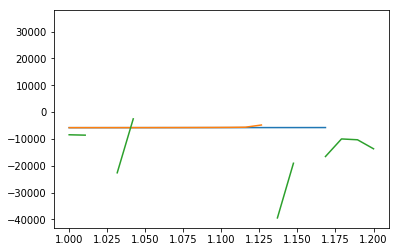

In [120]:
alphas = np.linspace(1,1.2,20)
vals = [L_biased(a) for a in alphas]
plt.plot(alphas,vals,label='1')
vals = [L_biased2(a) for a in alphas]
plt.plot(alphas,vals,label='2')
vals = [L_biased3(a) for a in alphas]
plt.plot(alphas,vals,label='3')

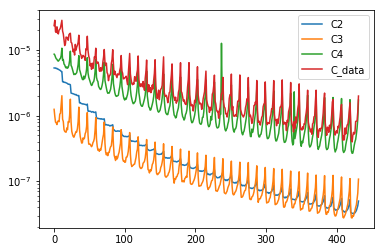

In [450]:
plt.plot(np.diag(c2),label='C2')
plt.plot(np.diag(c3),label='C3')
plt.plot(np.diag(c4),label='C4')
plt.plot(np.diag(data_cov),label='C_data')
plt.yscale('log')
plt.legend();

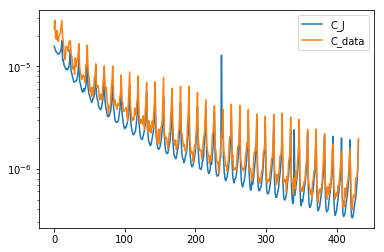

In [453]:
plt.plot(np.diag(c4+alpha_best*c3+alpha_best**2.*c2),label='C_J')
plt.plot(np.diag(data_cov),label='C_data')
plt.yscale('log');plt.legend();

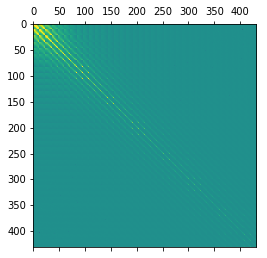

In [452]:
mat=c3
vmax = np.percentile(mat,99.9)
plt.matshow(mat,vmax=vmax,vmin=-vmax);
#plt.ylim([144,72])
#plt.xlim([72,144]);

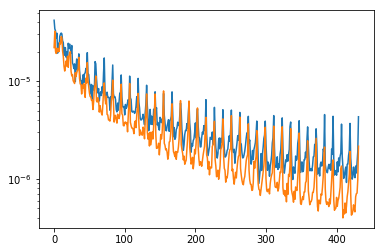

In [141]:
alpha=1.
qpm_cov = np.load('/mnt/store1/oliverphilcox/Mock1QPM2/98QPMCovariance.npy')
#plt.plot(np.diag(alpha**2*c2+alpha*c3+c4));
plt.plot(np.diag(qpm_cov),label='QPM')
plt.plot(np.diag(data_cov),label='Data Jackknife')
#plt.plot(np.diag(qpm_cov))
plt.yscale('log')

## Stacked Residual Plot

In [142]:
alpha_star = 1

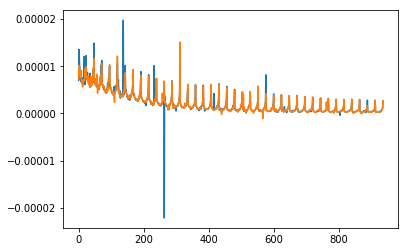

In [52]:
plt.plot(np.diag(c4s[5]))
plt.plot(np.diag(c4s[4]))

In [34]:
def neg_log_L1(alpha):
    """Return negative log L1 likelihood between data and theory covariance matrices"""
    Psi_alpha = Psi(alpha)
    logdet = np.linalg.slogdet(Psi_alpha)
    if logdet[0]<0:
        # Remove any dodgy inversions
        return np.inf        
    return np.trace(np.matmul(Psi_alpha,data_cov))-logdet[1]

In [21]:
def simple_L1(alpha):
    cov = c2*alpha**2.+c3*alpha+c4
    inv_cov = np.linalg.inv(cov)
    logdet = np.linalg.slogdet(cov)
    if logdet[0]<0:
        return np.inf
    return np.trace(np.matmul(inv_cov,data_cov))+logdet[1]

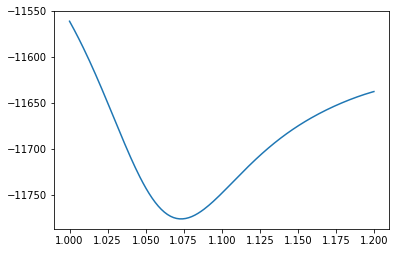

In [28]:
alphas = np.linspace(1,1.2,200)
plt.plot(alphas,[simple_L1(a) for a in alphas])

In [36]:
from scipy.optimize import minimize
out=minimize(neg_log_L1,1.)

In [37]:
out

      fun: inf
 hess_inv: array([[1]])
      jac: array([nan])
  message: 'Optimization terminated successfully.'
     nfev: 3
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([1.])

In [14]:
out.x

array([1.23699697])

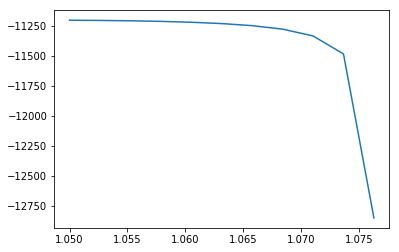

In [105]:
plt.plot(alphas,L1s)

In [86]:
c2ex,c3ex,c4ex=[],[],[]
for i in range(n_samples):
    c2ex.append(np.mean(c2s[:i]+c2s[i+1:],axis=0))
    c3ex.append(np.mean(c3s[:i]+c3s[i+1:],axis=0))
    c4ex.append(np.mean(c4s[:i]+c4s[i+1:],axis=0))

In [96]:
iden = np.eye(len(c2))
def minimizer(alpha):
    
    raise Exception("This is only dPsi/dalpha")
    c_tot = c2*alpha**2.+c3*alpha+c4
    inv_c_tot = np.linalg.inv(c_tot)
    grad_c_tot = 2.*c2*alpha+c3
    tmp_D=0.
    tmp_D_deriv=0.
    for i in range(n_samples):
        this_c = c2s[i]*alpha**2.+c3s[i]*alpha+c4s[i]
        c_excl = c2ex[i]*alpha**2.+c3ex[i]*alpha+c4ex[i]
        inv_c_excl = np.linalg.inv(c_excl)
        grad_this_c = 2.*c2s[i]*alpha+c3s[i]
        grad_c_excl = 2.*c2ex[i]*alpha+c3ex[i]
        tmp_D+=np.matmul(inv_c_excl,this_c)
        tmp = np.matmul(grad_c_excl,np.matmul(inv_c_excl,this_c))
        tmp_D_deriv+=np.matmul(inv_c_excl,grad_this_c-tmp)
    D = (n_samples-1.)/n_samples*(tmp_D/n_samples-iden)
    term1 = np.matmul(iden-D,np.matmul(inv_c_tot,np.matmul(grad_c_tot,inv_c_tot)))
    term2 = (n_samples-1.)/n_samples**2.*tmp_D_deriv
    return np.trace(term1+term2)

In [97]:
iden = np.eye(len(c2))
def minimizer_approx(alpha):
    c_tot = c2*alpha**2.+c3*alpha+c4
    inv_c_tot = np.linalg.inv(c_tot)
    grad_c_tot = 2.*c2*alpha+c3
    fact2 = iden - np.matmul(grad_c_tot,inv_c_tot)
    matrix = np.matmul(data_cov,np.matmul(inv_c_tot,fact2))
    return np.trace(matrix)

In [ ]:
from scipy.optimize

In [98]:
brentq(minimizer_approx,0.5,2.)

1.6394536025721826

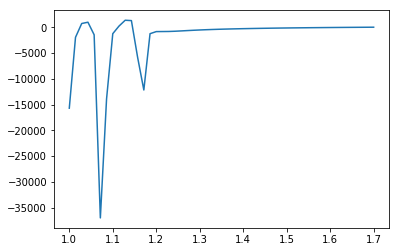

In [101]:
alphas = np.linspace(1.,1.7,50)
mins = [minimizer_approx(a) for a in alphas]
plt.plot(alphas,mins)

In [91]:
from scipy.optimize import brentq

In [94]:
alphas = np.linspace(0.5,2.,10)
funs = [minimizer(a) for a in alphas]

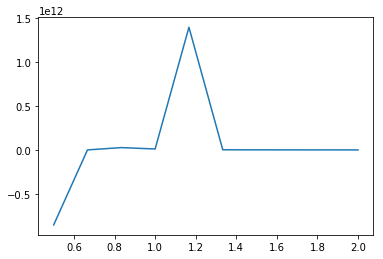

In [95]:
plt.plot(alphas,funs)

In [92]:
brentq(minimizer,0.5,2)

0.8890017401605148

In [71]:
fmin(neg_log_L1,1.76)

Optimization terminated successfully.
         Current function value: -11254.047610
         Iterations: 12
         Function evaluations: 24


array([1.6919375])

In [72]:
from scipy.optimize import brentq

def fn_to_solve(alpha):
    c_tot = c4+alpha*c3+alpha**2.*c2
    tmp = c3+2.*alpha*c2
    tmp2=np.matmul(data_cov-c_tot,np.matmul(c_tot,np.matmul(tmp,c_tot)))
    return np.trace(tmp2)

def fn_to_solve2(alpha):
    prec=Psi(alpha)
    inv_prec = np.linalg.inv(prec)
    tmp = c3+2.*alpha*c2
    tmp2=np.matmul(data_cov-inv_prec,np.matmul(inv_prec,np.matmul(tmp,inv_prec)))
    return np.trace(tmp2)

In [73]:
brentq(fn_to_solve,0,3)

1.7100398051529564

In [74]:
brentq(fn_to_solve2,0,3)

0.06674536661444672

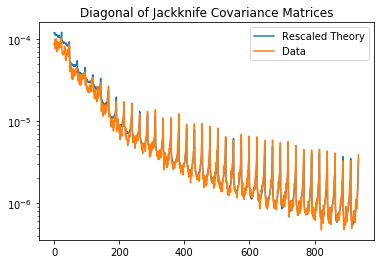

In [112]:
alpha_best=1.8
c_theory = alpha_best**2.*c2+alpha_best*c3+c4
plt.plot(np.diag(c_theory),label='Rescaled Theory')
plt.plot(np.diag(data_cov),label='Data')
plt.yscale('log');plt.title('Diagonal of Jackknife Covariance Matrices')
plt.legend();

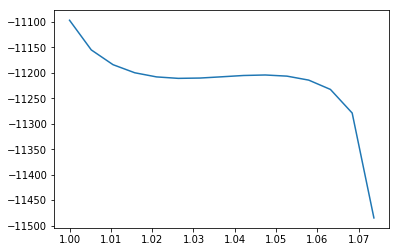

In [109]:
alphas = np.linspace(1.0,1.1,20)
funs = [neg_log_L1(a) for a in alphas]
plt.plot(alphas,funs)

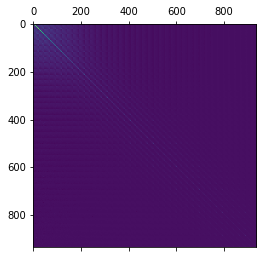

In [110]:
plt.matshow(c_theory)

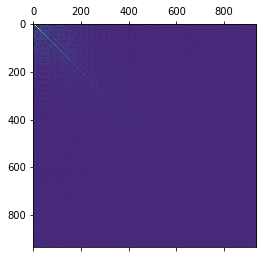

In [111]:
plt.matshow(data_cov)

## Test output

In [1]:
%pylab inline
data=np.load('../../mock1/Rescaled_Covariance_Matrices_n39_m24_j169.npz')

Populating the interactive namespace from numpy and matplotlib


In [3]:
%pylab inline
data=np.load('../../mock1/Rescaled_Covariance_Matrices_n39_m24_j169.npz')

def whiten(mat):
    diag = np.asmatrix(np.diag(mat))
    return mat/np.sqrt(np.matmul(diag.T,diag))

cov=data.f.full_theory_covariance
prec=data.f.full_theory_precision
data_cov = data.f.jackknife_data_covariance
D = data.f.full_theory_D_matrix
ind_cov = data.f.individual_theory_covariances

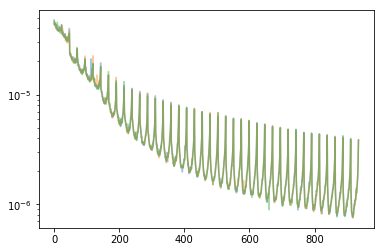

In [13]:
for i in range(3):
    plt.plot(np.diag(ind_cov[i]),alpha=0.4)
plt.yscale('log')

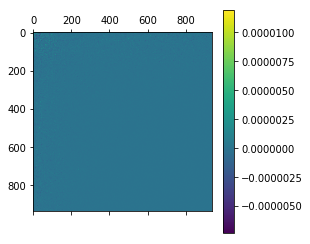

In [14]:
plt.matshow(ind_cov[10]-ind_cov[7]);plt.colorbar()

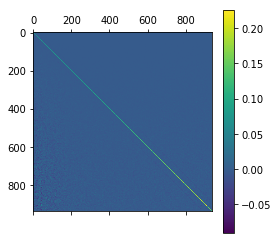

In [5]:
plt.matshow(D);plt.colorbar();

In [59]:
len(D)/np.exp(np.linalg.slogdet(D)[1]/len(D))

10774.426249388594

(360, 240)

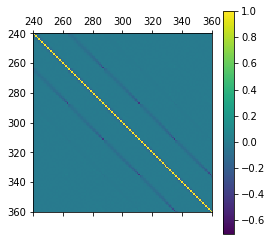

In [36]:
plt.matshow(whiten(prec));plt.colorbar()
plt.xlim([240,360]);plt.ylim([360,240])

In [32]:
data.f.N_eff

array(-588646.91918145)

## Check RR consistency

In [117]:
N_g = 642051
N_r = 6420510

In [118]:
RR_rascal = np.loadtxt('../../mock1/RR_n39_m24_11_full.txt')

In [119]:
RR_corrfunc=np.loadtxt('../../mock1/binned_pair_counts_n39_m24_j169_11.dat')*(float(N_g)/float(N_r))**2.

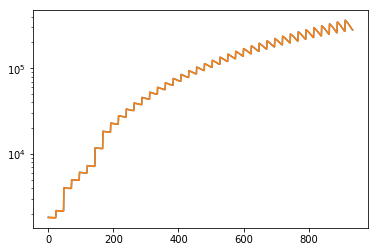

In [120]:
plt.plot(RR_corrfunc)
plt.plot(RR_rascal)
plt.yscale('log')

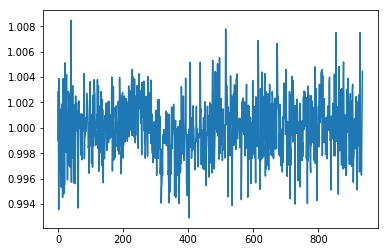

In [121]:
plt.plot(RR_rascal/RR_corrfunc)